In [14]:
import tkinter as tk
from tkinter import filedialog
from tkinter import messagebox
import warnings
from tkinter import simpledialog
from tkinter import Tk, Label, Button, Radiobutton, IntVar
import h5py
from skimage.external import tifffile
import numpy as np
from skimage import transform
from scipy.ndimage import zoom
#from GUV_Analysis_Module import *
import napari
import time
import matplotlib
#matplotlib.use('Qt4Agg')


In [2]:
#Ignore warnings issued by skimage through conversion to uint8
warnings.simplefilter("ignore",UserWarning)
warnings.simplefilter("ignore",RuntimeWarning)
warnings.simplefilter("ignore",FutureWarning)
# Use tkinter to interactively select files to import
root = tk.Tk()
root.withdraw()

GUV_Post_Analysis_df_list = []

my_filetypes = [('all files', '.*'),('Image files', '.hdf5')]

filez = filedialog.askopenfilenames(parent = root, title='Please Select a File', filetypes = my_filetypes)

file_name= root.tk.splitlist(filez)[0]

f = h5py.File(file_name, 'r')

In [3]:
image = f['561 Channel'][:]

intensity_image = f['488 Channel'][:]

#image = image + intensity_image

time_len = float(input("How long is the movie in minutes? "))


How long is the movie in minutes? 36


In [7]:
def pt_dist_extractor(line_data_list):
    point_list = []
    line_list = []
    z_list = []
    for num in range(len(line_data_list)):

        pt = line_data_list[num]
        #print(pt)
        x = pt[0][3]
        y = pt[0][2]
        z = pt[0][1]

        x1 = pt[1][3]
        y1 = pt[1][2]

        point = np.array((x,y))
        point2 = np.array((x1,y1))

        length = np.linalg.norm(point2-point)
        point_list.append(point)
        line_list.append(length)
        z_list.append(z)

    return (point_list, line_list,z_list)



In [5]:
%gui qt5

In [9]:

viewer = napari.Viewer()
viewer.add_image(image, name='561', colormap='red',blending = 'opaque')
viewer.add_image(intensity_image,name='488',colormap='green',blending = 'additive')
line_layer = viewer.add_shapes(shape_type='line', edge_width=1.5, face_color = 'blue', edge_color = 'b')














  0%|          | 0/1 [00:00<?, ?it/s]









Measure Volume:   0%|          | 0/1 [00:00<?, ?it/s]










  0%|          | 0/109 [00:00<?, ?it/s]










Find mid planes:   0%|          | 0/109 [00:00<?, ?it/s]

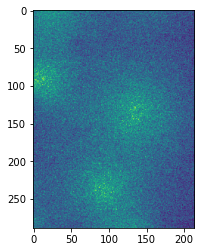

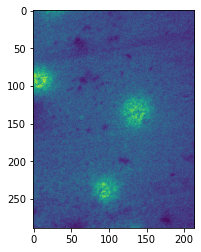

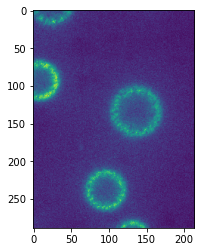

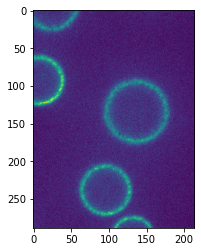

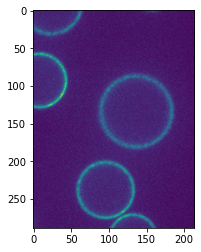

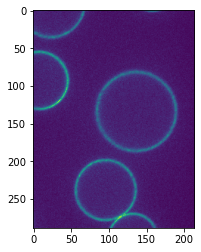

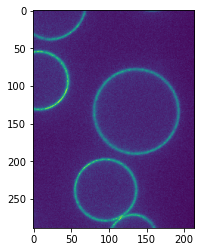

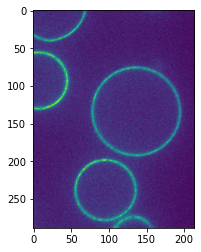

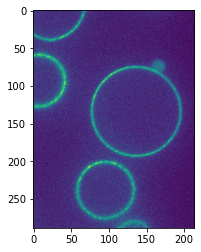

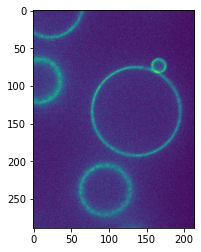

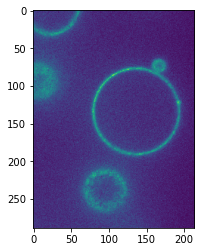

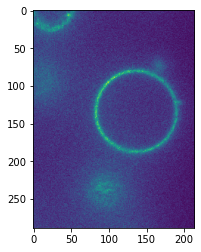

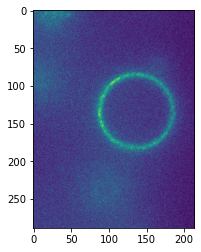

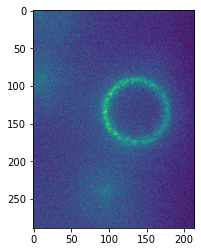

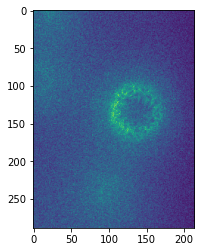

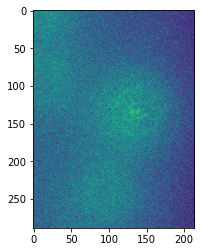

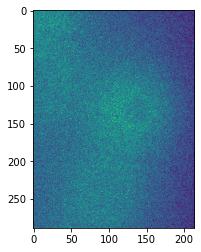

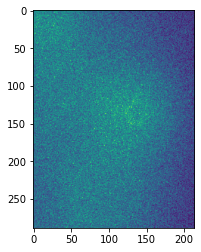

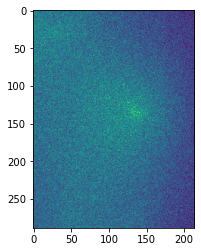

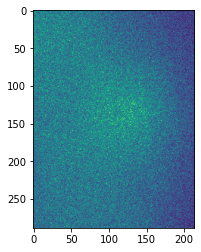

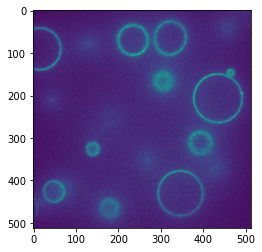

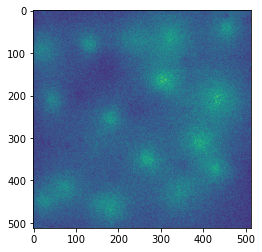

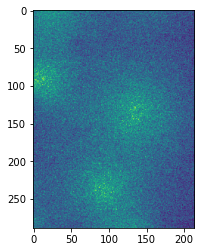

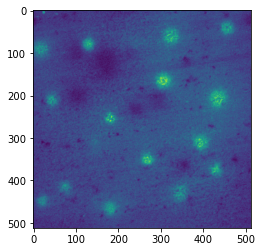

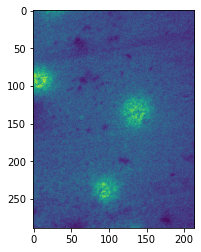

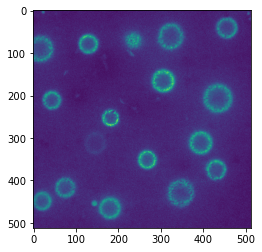

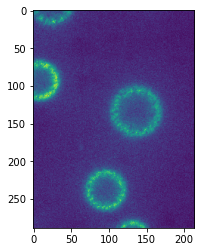

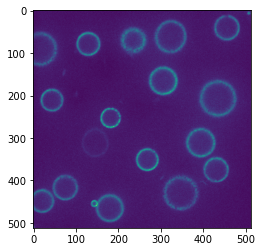

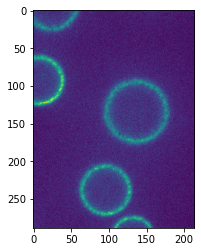

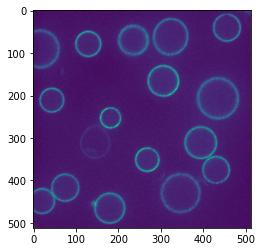

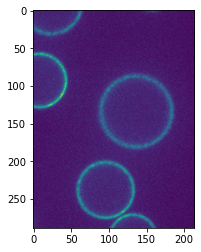

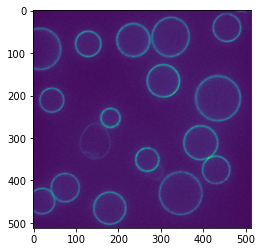

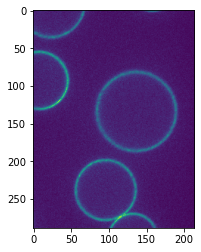

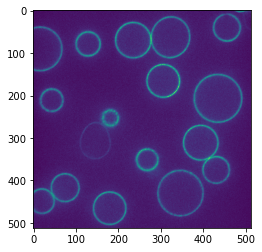

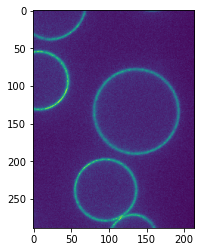

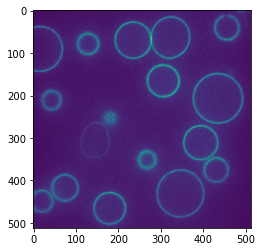

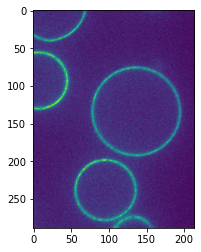

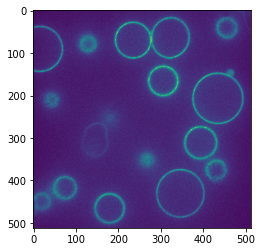

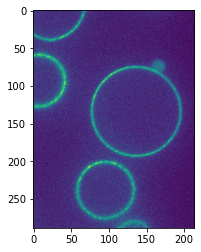

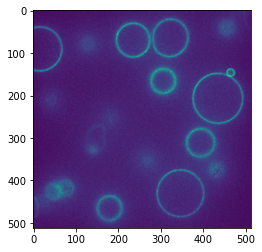

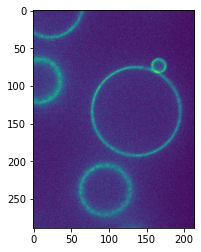

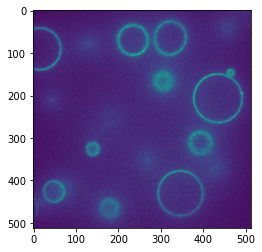

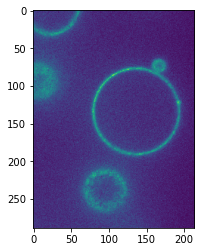

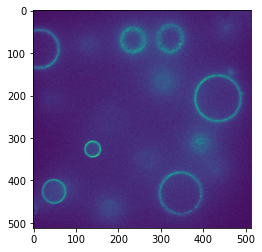

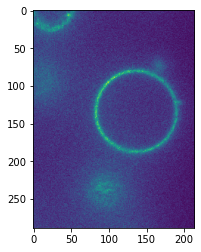

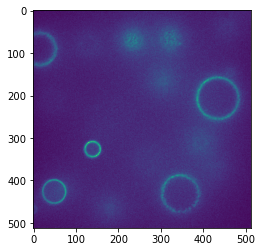

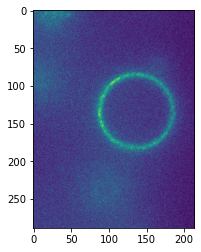

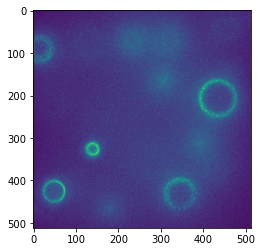

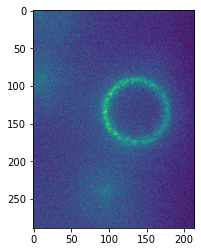

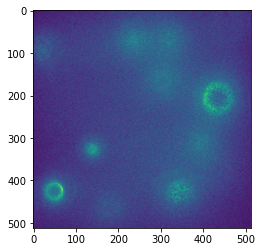

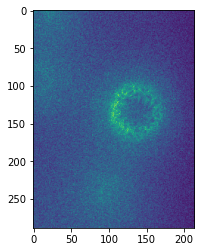

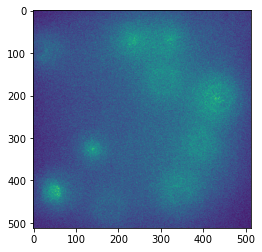

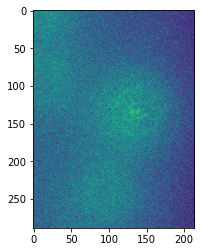

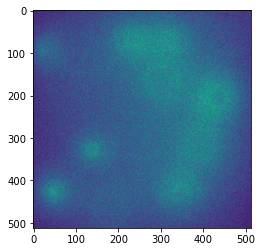

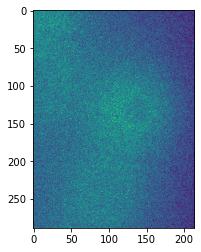

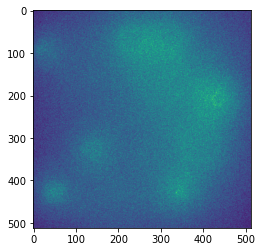

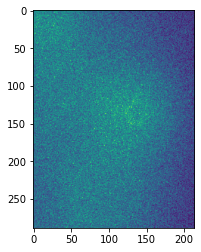

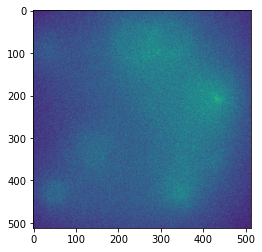

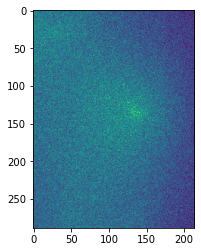

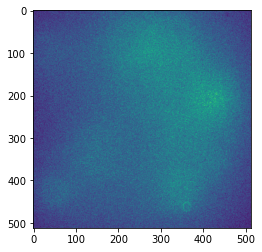

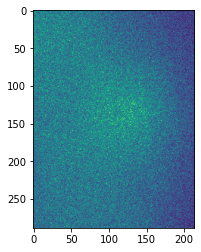

NameError: name 'bg_seed' is not defined

In [23]:
line_data = line_layer.data
point_list, line_list,z_list= pt_dist_extractor(line_data)
Analysis_Stack = Image_Stacks(image,intensity_image,point_list,line_list,z_list,2000,time_len)
Analysis_Stack.tracking_multiple_circles_3d()
viewer.add_image(Analysis_Stack.binary_shell_list,name='3D_Volume', blending = 'additive')


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from scipy import ndimage
from skimage.measure import ransac, CircleModel, label, regionprops
from matplotlib.patches import Circle
import cv2
import math
from skimage import feature
from skimage import morphology
import pandas as pd
from matplotlib import gridspec
from matplotlib.pyplot import cm
from skimage.filters import threshold_otsu
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
from colorama import Fore
from skimage import img_as_ubyte
from scipy.ndimage import gaussian_filter, binary_fill_holes
from pre_processing_utils import *
from skimage.morphology import disk, watershed
from utils import *
import warnings
#import multiprocessing
from scipy.ndimage import gaussian_filter
from skimage.exposure import equalize_hist
#multiprocessing.set_start_method('spawn', True)
from skimage import draw
import mplcursors

warnings.simplefilter("ignore",FutureWarning)

def get_3dseed_from_mid_frame(bw, point):
    
    # build the seed for watershed
    seed = np.zeros(bw.shape)
    seed_count=0
    if bg_seed:
        seed[0,:,:] = 1
        seed_count += 1
    
    px,py,pz = point

    seed[int(pz),int(py),int(px)]= seed_count

    return seed
    
    return seed




def draw_GUV_contour_3d(img_stk, point,mid_num,width,dist,factor,intensity_norm):
    #print(img.shape)
    bw_shell_output = np.zeros(img_stk.shape)
    
    Crop_list = []

    for im in img_stk:
      #plt.imshow(im)
      #plt.show()
      img_c,X,Y = crop_image(im, point, dist, dist, factor=factor, XY_return= True)
      #img_c = equalize_hist(img_c)

      Crop_list.append(img_c)
      #plt.imshow(img_c)
      #plt.show()

    Crop_list = np.array(Crop_list)

    Crop_list = intensity_normalization(Crop_list,[intensity_norm])


    seed = get_3dseed_from_mid_frame(Crop_list,point = (1.4*dist,1.4*dist,mid_num)).astype(int)
    bw_filled = watershed(Crop_list, markers=seed, watershed_line=True) > 0
    bw_shell = np.logical_xor(bw_filled, morphology.dilation(bw_filled, selem=disk(width))).astype(int)

    #print(bw_shell_output[int(round(Y)):int(round(Y+factor*dist)),int(round(X)):int(round(X + factor * dist))].shape == bw_shell.shape)

    bw_shell_filled = binary_fill_holes(bw_shell).astype(int)
    bw_shell_filled_whole = bw_shell_output.copy()
    bw_shell_filled_whole[:,int(round(Y)):int(round(Y+factor*dist)),int(round(X)):int(round(X + factor * dist))] = bw_shell_filled

    bw_shell =  np.logical_xor(bw_shell_filled, morphology.dilation(bw_shell_filled, selem=disk(width))).astype(int)
    bw_shell_output[:,int(round(Y)):int(round(Y+factor*dist)),int(round(X)):int(round(X + factor * dist))] = bw_shell
    region = regionprops(label(bw_shell_filled_whole))

    index = np.argmax([r.area for r in region])
    #eccentricity = np.min([r.eccentricity for r in region])
    volume = region[index].area
    center = (region[index].centroid[2], region[index].centroid[1])
    return bw_shell_output,radius, center


# Pick Middle frame through the largest area of identified object after watershed.
def mid_frame_picker_area(img_stack,point):

   max_area_list = []
   eccentricity_list = []
   MI = np.max(img_stack, axis = 0)
   #plt.imshow(MI)
   #plt.scatter(point[0],point[1],color = 'red')
   #plt.show()

   #f2_param = [[0.5, 0.5]]
   #bw = filament_2d_wrapper(MI,f2_param)
   #bw = remove_small_objects(bw>0, 100)
   #bw = binary_fill_holes(bw).astype(int)

   #plt.imshow(bw)
   #plt.show()
   seed = get_seed_from_MI_frame(MI,point).astype(int)

   bw_shell_list = []
   for n in range(img_stack.shape[0]):
     img = img_stack[n,:,:]

     bw_filled = watershed(img,markers = seed, watershed_line=True)>0
     bw_shell = np.logical_xor(bw_filled, morphology.dilation(bw_filled, selem = disk(1))).astype(int)

     bw_shell = binary_fill_holes(bw_shell).astype(int)


     bw_shell_list.append(bw_shell)

     out1 = label(bw_shell)
     stat = regionprops(out1)


     max_area = np.max([r.area for r in stat])
     eccentricity_list.append(np.min([r.eccentricity for r in stat]))
     max_area_list.append(max_area)

   bw_shell_list = np.array(bw_shell_list)
   '''
   fig = plt.figure(figsize=(18,10))

   for n in range(0,len(img_stack),1):
      a = fig.add_subplot(1, np.ceil(len(bw_shell_list)/float(1)), n/1 + 1)
      #print(n)
      plt.imshow(bw_shell_list[n,:,:])
      plt.axis('off')

   plt.show()
   '''


   #max_a = smooth(max_a)
   max_area_list = np.array(max_area_list)
   eccentricity_list = np.array(eccentricity_list)
   #plt.plot(max_a)
   num = np.argmax(max_area_list)

   if eccentricity_list[num] > 0.7:
     ecc_list_less_ind = np.array(np.where(eccentricity_list <= 0.7))[0]
     new_max_area_list = max_area_list[ecc_list_less_ind]
     num = ecc_list_less_ind[np.argmax(new_max_area_list)]

   #plt.scatter(num, max_a[num], c= 'r')
   #plt.show()
   mid_frame = int(num)

   return mid_frame



# Define a function to plot both radius and protein intensity from a list of pandas df
def Pandas_list_plotting(pandas_list, keyword, marker = None):
    fig= plt.figure(figsize = (10,6))
    gs = gridspec.GridSpec(1,1)

    ax = fig.add_subplot(gs[:,:])

    list_len = len(pandas_list)
    color = cm.tab20b(np.linspace(0,1,list_len))

    if keyword == 'Normalized Intensity':
      ax.set_title('Vesicles Protein Bindings Changes',fontsize=18)

      ax.set_xlabel('Time Points (min)', fontsize = 16, fontweight = 'bold')
      ax.set_ylabel('Protein Fluorescence Intensity', fontsize = 16,fontweight = 'bold')

      for n in range(list_len):
         df = pandas_list[n]
         Intensity_data = df['Normalized GFP intensity'].tolist()
         Time_point = df['Time Point'].tolist()
         ax = plt.plot(Time_point, Intensity_data, color = color[n], label = str(n), marker = marker)

    if keyword == 'Radius':
      ax.set_title('Vesicles Radius Changes (um)',fontsize=18)

      ax.set_xlabel('Time Points (min)', fontsize = 16, fontweight = 'bold')
      ax.set_ylabel('Vesicles Radius (um)', fontsize = 16,fontweight = 'bold')

      for n in range(list_len):
         df = pandas_list[n]
         radius_data = df['radius_micron'].tolist()
         Time_point = df['Time Point'].tolist()
         ax = plt.plot(Time_point, radius_data, color = color[n], label = str(n), marker = marker)
    
    if keyword == 'Volume':
      ax.set_title('Vesicles Volume Changes (um)',fontsize=18)

      ax.set_xlabel('Time Points (min)', fontsize = 16, fontweight = 'bold')
      ax.set_ylabel('Vesicles Volumes ', fontsize = 16,fontweight = 'bold')

      for n in range(list_len):
         df = pandas_list[n]
         v_data = df['volume'].tolist()
         Time_point = df['Time Point'].tolist()
         ax = plt.plot(Time_point, v_data, color = color[n], label = str(n), marker = marker)

    plt.legend(loc='right')
    plt.tight_layout()
    mplcursors.cursor(highlight=True,hover=True)
    plt.show()


def crop_image(Image,center,width,height,factor=3,XY_return = False):
    low_point = (center[0] - 1.4 * width, center[1] - 1.4 * height)
    X,Y = low_point

    if X < 0:
      X =0

    if X > 512:
      X = 512

    if Y < 0:
      Y = 0

    if Y > 512:
      Y = 512

    Crop_image = Image[int(round(Y)):int(round(Y+factor*height)),int(round(X)):int(round(X + factor * width))]


    if XY_return == False:
      return Crop_image
    else:
      return Crop_image, X, Y

def creating_mask(Image,center,width,height,factor=2):
    Y,X = np.ogrid[:Image.shape[0],:Image.shape[1]]

    low_point = (center[0] - 1.4*width, center[1] - 1.4*height)
    X_low,Y_low = low_point

    X_low = int(X_low)
    Y_low = int(Y_low)

    X_high = int(round(X_low+factor*width))
    Y_high = int(round(Y_low+factor*height))


    mask_image = (Y >= Y_low) & (Y <= Y_high) & (X >= X_low) & (X <= X_high)

    return mask_image



def generate_df_from_list(pixel_attribute,total_time, center_list,r_list,intensity_list,z_num_list):

    time_point_list = np.linspace(0, total_time, num = len(center_list))
    center_list = np.array(center_list)
    center_x = center_list [:,0]
    center_y = center_list[:,1]

    r_list = np.array(r_list)
    r_list_micron = r_list * pixel_attribute

    Normalized_intensity_list= np.array(intensity_list)
    
    
    z_num_list = np.array(z_num_list)
    
    stat_dict = {'Time Point': time_point_list,'center_x': center_x, 'center_y': center_y, 'radius': r_list, 'radius_micron':r_list_micron, 'Normalized GFP intensity': Normalized_intensity_list,'Median Slice Number': z_num_list}
    
    stat_df = pd.DataFrame(stat_dict)

    return stat_df

def generate_df_from_list_3D(total_time, center_list,v_list,z_num_list):

    time_point_list = np.linspace(0, total_time, num = len(center_list))
    center_list = np.array(center_list)
    center_x = center_list [:,0]
    center_y = center_list[:,1]
    z_num_list = np.array(z_num_list)

    v_list = np.array(v_list)
    #r_list_micron = r_list * pixel_attribute

    stat_dict = {'Time Point': time_point_list,'center_x': center_x, 'center_y': center_y, 'volume': v_list,  'center_z': z_num_list}
    
    stat_df = pd.DataFrame(stat_dict)

    return stat_df

# define a function to pick best plane from cropped image stack
def mid_slice_picker(img_stack,center, dist,intensity_norm):
   #for n in range(img_stack.shape[0]):
    # _,_,img_stack[n,:,:] = enhance_blur_medfilter(img_stack[n,:,:], enhance= True,blur=True, kernal = 7, median_filter= True, size = 2)

   Crop_list = []

   for img in img_stack:
     img_c = crop_image(img, center, dist, dist, factor=3.0)
     plt.imshow(img_c)
     plt.show()
     #img_c = equalize_hist(img_c)

     Crop_list.append(img_c)

   Crop_list = np.array(Crop_list)

   Crop_list = intensity_normalization(Crop_list,[intensity_norm])

   '''
   fig = plt.figure(figsize=(18,8))
   for n in range(0,len(Crop_list),1):
      a = fig.add_subplot(1,  np.ceil(len(Crop_list)/float(1)), n/1 + 1)
      plt.imshow(Crop_list[n,:,:])
      plt.axis('off')

   plt.show()
   '''
   point = (1.4*dist,1.4*dist)
   #mid_z = get_middle_frame(Crop_list, 'intensity')
   mid_z= mid_frame_picker_area(Crop_list,point)


   #mid_intensity_img = gaussian_filter(Intensity_img_stack[mid_z,:,:],3,truncate=3.0)
   #mid_img = gaussian_filter(img_stack[mid_z,:,:],3,truncate=3.0)
   #plt.imshow(mid_intensity_img, cmap = Green)
   #plt.axis('off')
   #plt.show()

   #plt.imshow(Crop_list[mid_z,:,:], cmap = Red)
   #plt.axis('off')
   #plt.show()
   return mid_z


# Define a class to store and process the time series Images
class Image_Stacks:

     def __init__ (self,vesicle_image,GFP_image_z,point_list,dist_list,z_list,upper_limit,total_time):
         self.Image_stack = vesicle_image.copy()
         self.Intensity_stack = GFP_image_z.copy()
         self.Micron_Pixel = 0.33
         self.intensity_enhance = False
         self._enhance = None
         self._blur = None
         self._kernal = None
         self.median_filter = None
         self.size = None
         self.point = None
         self.point_list = point_list
         self.stats_df_list = []
         self.dist = dist_list
         self.binary_shell_list = np.zeros(self.Image_stack.shape)
         self.upper_limit = upper_limit
         self.z_list = z_list
         self.time_len = total_time
         
     def tracking_single_circle(self,num):
        num_len = self.Image_stack.shape[0]
        center_list = []
        r_list = []
        GFP_list = []
        z_num_list = []
        self.point = self.point_list[num]
        #print(num_len)
        pb = tqdm(range(num_len), bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.LIGHTCYAN_EX, Fore.RESET))
        for n in pb:
           pb.set_description ('Find mid planes and measure intensity')
           #print("Analyze GUV "+ str(num) + " Frame " + str(n))
           Image_stack_n = self.Image_stack[n,:,:,:]

           Intensity_stack_n = self.Intensity_stack[n,:,:,:]

           try:
               z_num = mid_slice_picker(Image_stack_n,self.point, self.dist[num],self.upper_limit)
               #print(z_num)
               Median_Intensity_Slice = gaussian_filter(Intensity_stack_n[z_num,:,:],3,truncate=3.0)
               median_img = Image_stack_n[z_num,:,:]


           except:
            if n == 0:
                #print(self.point_list)
                z_num = int(self.z_list[num])
                Median_Intensity_Slice = gaussian_filter(Intensity_stack_n[z_num,:,:],3,truncate=3.0)
                median_img = Image_stack_n[z_num,:,:]

                #plt.imshow(median_img)
                #plt.show()

                #binary_shell_temp,r,center = draw_GUV_contour(median_img,self.point,3,self.dist[num],3.0)

            else:
                z_num = z_num_list[-1] - 1
                Median_Intensity_Slice = gaussian_filter(Intensity_stack_n[z_num,:,:],3,truncate=3.0)
                median_img = Image_stack_n[z_num,:,:]

                #binary_shell_temp,r,center = draw_GUV_contour(median_img,self.point,3,self.dist[num],3.0)

            print('Middle Frame Error')

           if n >0 :
             if abs(z_num - (z_num_list[-1] - 1)) >= 4:
              #print("n too far")
              z_num = z_num_list[-1] - 1
              Median_Intensity_Slice = gaussian_filter(Intensity_stack_n[z_num,:,:],3,truncate=3.0)
              median_img = Image_stack_n[z_num,:,:]

              #binary_shell_temp,r,center = draw_GUV_contour(median_img,self.point,3,self.dist[num],3.0)

           #try:
             #center,r = fit_circle_contour(median_img, self.point, self.width[num],self.height[num])

    
           #center,r,binary_shell_temp = fit_circle_contour(median_img, self.point,self.dist[num],self.dist[num],self.upper_limit)
           binary_shell_temp,r,center = draw_GUV_contour(median_img,self.point,3,self.dist[num],3.0,self.upper_limit)

           if r <= 0.2 * self.dist[num] or r >= 1.4* self.dist[num]:
             #print ('r too small!')
             center = self.point
             if n != 0:
                r = r_list[-1]
                binary_shell_temp = binary_shell
             else:
                #print('None Exception')
                r = self.dist[num]

           binary_shell = binary_shell_temp
           self.point = center
           center_list.append(center)
           r_list.append(r)



           #print(z_num)
           Intensity = obtain_ring_pixel(Median_Intensity_Slice,binary_shell)
           GFP_list.append(Intensity)
           self.binary_shell_list[n,z_num,:,:] += binary_shell
           #self.middle_slice_stack[n,:,:] = median_img
           #self.middle_slice_stack_intensity[n,:,:] = Median_Intensity_Slice

           z_num += 1
           z_num_list.append(z_num)

        stats_df = generate_df_from_list(self.Micron_Pixel,self.time_len, center_list,r_list,GFP_list, z_num_list)

        return stats_df

     def tracking_multiple_circles(self):
        num = len(self.point_list)

        #try:
        #self.stats_df_list = Parallel(n_jobs=-1)(delayed(self.tracking_single_circle)(n) for n in range(num))

        #except:
          #print("Parallel Failed, using single thread")

        pb = tqdm(range(num), bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.RED, Fore.RESET))
        for n in pb:
          pb.set_description("Fitting Circles on GUV and Measure Protein Fluorescence")
          df = self.tracking_single_circle(n)
          self.stats_df_list.append(df)

    
     def tracking_single_circle_3d(self,num):
        num_len = self.Image_stack.shape[0]
        center_list = []
        volume_list = []
        z_num_list = []
        self.point = self.point_list[num]
        #print(num_len)
        pb = tqdm(range(num_len), bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.LIGHTCYAN_EX, Fore.RESET))
        for n in pb:
           pb.set_description ('Find mid planes')
           #print("Analyze GUV "+ str(num) + " Frame " + str(n))
           Image_stack_n = self.Image_stack[n,:,:,:]

           try:
               z_num = mid_slice_picker(Image_stack_n,self.point, self.dist[num],self.upper_limit)
               #print(z_num)


           except:
            if n == 0:
                #print(self.point_list)
                z_num = int(self.z_list[num])
              
            else:
                z_num = z_num_list[-1] - 1
                

            print('Middle Frame Error')

           if n >0 :
             if abs(z_num - (z_num_list[-1] - 1)) >= 4:
              #print("n too far")
              z_num = z_num_list[-1] - 1
              
           plt.imshow(Image_stack_n[10,:,:])
           plt.show()
           binary_shell_temp,v,center = draw_GUV_contour_3d(Image_stack_n,self.point,z_num, 3,self.dist[num],3.0,self.upper_limit)
           '''
           if r <= 0.2 * self.dist[num] or r >= 1.4* self.dist[num]:
             #print ('r too small!')
             center = self.point
             if n != 0:
                r = r_list[-1]
                binary_shell_temp = binary_shell
             else:
                #print('None Exception')
                r = self.dist[num]
           '''
           binary_shell = binary_shell_temp
           self.point = center
           center_list.append(center)
           volume_list.append(v)


           self.binary_shell_list[n,:,:,:] = binary_shell
           #self.middle_slice_stack[n,:,:] = median_img
           #self.middle_slice_stack_intensity[n,:,:] = Median_Intensity_Slice

           z_num += 1
           z_num_list.append(z_num)

        stats_df = generate_df_from_list(self.time_len, center_list,v_list, z_num_list)

        return stats_df

     def tracking_multiple_circles_3d(self):
        num = len(self.point_list)

        #try:
        #self.stats_df_list = Parallel(n_jobs=-1)(delayed(self.tracking_single_circle)(n) for n in range(num))

        #except:
          #print("Parallel Failed, using single thread")

        pb = tqdm(range(num), bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.RED, Fore.RESET))
        for n in pb:
          pb.set_description("Measure Volume")
          df = self.tracking_single_circle_3d(n)
          self.stats_df_list.append(df)
          
class Image_Stacks_Single_Plane:

     def __init__ (self,vesicle_image,GFP_image_z,point_list,dist_list,upper_limit,total_time):
         self.Image_stack = vesicle_image.copy()
         self.Intensity_stack = GFP_image_z.copy()
         self.Micron_Pixel = 0.33
         self.intensity_enhance = False
         self.size = None
         self.point = None
         self.point_list = point_list
         self.stats_df_list = []
         self.dist = dist_list
         self.binary_shell_list = np.zeros(self.Image_stack.shape)
         self.upper_limit = upper_limit
         self.time_len = total_time
         
     def tracking_single_circle_single_plane(self,num):
        num_len = self.Image_stack.shape[0]
        center_list = []
        r_list = []
        GFP_list = []
        self.point = self.point_list[num]
        #print(num_len)
        pb = tqdm(range(num_len), bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.LIGHTCYAN_EX, Fore.RESET))
        for n in pb:
           pb.set_description ('Draw contours and measure intensity')
           #print("Analyze GUV "+ str(num) + " Frame " + str(n))
           Image_stack_n = self.Image_stack[n,:,:]

           Intensity_stack_n = self.Intensity_stack[n,:,:]

           Median_Intensity_Slice = gaussian_filter(Intensity_stack_n,3,truncate=3.0)

           binary_shell_temp,r,center = draw_GUV_contour(Image_stack_n,self.point,3,self.dist[num],3.0,self.upper_limit)

           if r <= 0.2 * self.dist[num] or r >= 1.4* self.dist[num]:
             #print ('r too small!')
             center = self.point
             if n != 0:
                r = r_list[-1]
                binary_shell_temp = binary_shell
             else:
                #print('None Exception')
                r = self.dist[num]

           binary_shell = binary_shell_temp
           self.point = center
           center_list.append(center)
           r_list.append(r)

           Intensity = obtain_ring_pixel(Median_Intensity_Slice,binary_shell)
           GFP_list.append(Intensity)
           self.binary_shell_list[n,:,:] += binary_shell
           

  

        stats_df = generate_df_from_list_single_plane(self.Micron_Pixel,self.time_len, center_list,r_list,GFP_list)

        return stats_df

     def tracking_multiple_circles_single_plane(self):
        num = len(self.point_list)

        #try:
        #self.stats_df_list = Parallel(n_jobs=-1)(delayed(self.tracking_single_circle)(n) for n in range(num))

        #except:
          #print("Parallel Failed, using single thread")

        pb = tqdm(range(num), bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.RED, Fore.RESET))
        for n in pb:
          pb.set_description("Fitting Circles on GUV and Measure Protein Fluorescence")
          df = self.tracking_single_circle_single_plane(n)
          self.stats_df_list.append(df)

 